## Linear Regression and RANSAC

In [5]:
# Load the modules we need
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets
from scipy import stats

In [6]:
#  Create some intial data
n_samples = 1000

X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      random_state=0)

In [7]:
# Add some outlier data
np.random.seed(0)
n_outliers = 50
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

In [8]:
# Create some test positions for for the lines we will draw
line_X = np.arange(X.min(), X.max())[:, np.newaxis]

In [9]:
#linear regression using closed loop form
class LinearReg:
    
    def fit(self, X,y):
        test_X= np.ones((X.shape[0],2))
        test_X[:,0]=X[:,0]
        X=test_X
        y=np.reshape(y, (1000, 1))
        #using pseudo inverse to find w(gradient and y intercept)
        self.w= np.dot(np.linalg.pinv( (np.dot( np.transpose(X) , X )) ) , ( np.dot( np.transpose( X ) , y )))
        return self.w
    
    def predict(self, X):
        test_X= np.ones((X.shape[0],2))
        test_X[:,0]=X[:,0]
        prediction=np.zeros((X.shape[1],X.shape[0]))
        for i in range(prediction.shape[1]):
            #using w we are able to form a line as a prediction
            prediction[:,i] = np.dot(self.w[0],test_X[i][0]) + self.w[1] 
        prediction=np.reshape(prediction,(8,1))
        return prediction
    
lr = LinearReg()
test=lr.fit(X,y)
line_y= lr.predict(line_X)

In [10]:
class RANSACReg:
    
    def fit(self, X, y):
        #threshold chosen through trial and error
        threshold=0.3
        s=2
        N=100
        minInliers = 935
        self.bestLine = None
        mostInliers = 0
        for i in range(N):
            pool = np.random.choice(X.shape[0], size=s, replace=False)
            mc = self.findEqOfLine(X[pool], y[pool])
            currentInliers = self.checkInliers(X, y, mc ,threshold)
            if currentInliers < minInliers:
                continue

            elif currentInliers > mostInliers:
                self.finalInliers=self.inliers
                self.bestLine = mc
                mostInliers = currentInliers
            
        return self.bestLine
    
    #used to find the y-intercept and gradient of a line from two points
    def findEqOfLine(self, X, y):
        A= np.ones((X.shape[0],2))
        A[:,0]=X[:,0]
        mc = np.linalg.lstsq(A, y, rcond=None)[0]
        return mc
    
    #count number of inliers and outliers
    def checkInliers(self, X, y, mc, rang):
        #mx+c-y=0
        A = np.ones((X.shape[0],3))
        y = y.reshape((y.shape[0], 1))
        #make the y negative
        y=y*(-1)
        A[:,0]=y[:,0]
        A[:,1]=X[:,0]
        #used to reshape for multiplication to form ax + by + c
        #-a/b is m (gradient)
        mc = np.insert(mc, 0, 1)
        #distance from point to line equation
        dist = np.abs(np.sum(A*mc, axis=1)) / np.sqrt(np.sum(np.square(mc[:-1])))
        self.inliers=dist < rang
        num=np.count_nonzero(self.inliers == True)
        return num
    
    def getInliers(self):
        return self.finalInliers
    
    #predict a line using the gradient and y-intercept with most inliers
    def predict(self, X):
        test_X=np.ones((X.shape[0],2))
        test_X[:,0]=X[:,0]
        prediction=np.zeros((X.shape[1],X.shape[0]))
        for i in range(prediction.shape[1]):
            prediction[:,i] = np.dot(self.bestLine[0],test_X[i][0]) + self.bestLine[1]
        prediction=np.reshape(prediction,(8,1))
        return prediction
    
ransac = RANSACReg()
ransac.fit(X,y)
line_y_ransac = ransac.predict(line_X)
inlier_mask = ransac.getInliers()
outlier_mask = np.logical_not(inlier_mask)

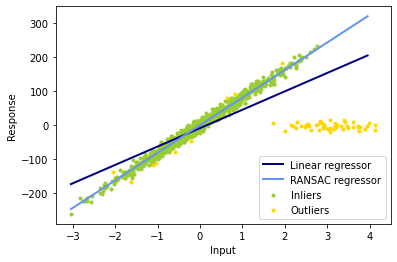

In [11]:
lw = 2

doing_linear = True
doing_ransac = True

if (doing_linear):
    plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')

if (doing_ransac):
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')
    plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw, label='RANSAC regressor')
else:
    plt.scatter(X, y, color='yellowgreen', marker='.', label='Data')
    
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()